## Análisis del Problema
Se quiere identificar caras de personas y con la información obtenida de poder decir si es hombre o mujer, esto por medio de un sistema CNN.

#CNN
### Autores
   * Daniela Alvarado
   * Gustavo Méndez

##Librerias

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Entendimiento de los Datos

In [ ]:
!wget https://www.dropbox.com/s/s5n3rb4sg6twuyq/faces.zip

--2022-06-02 14:20:19--  https://www.dropbox.com/s/s5n3rb4sg6twuyq/faces.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s5n3rb4sg6twuyq/faces.zip [following]
--2022-06-02 14:20:19--  https://www.dropbox.com/s/raw/s5n3rb4sg6twuyq/faces.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc64116f015b2543c3be7bffa715.dl.dropboxusercontent.com/cd/0/inline/Bmdxgn2IzpySgUAJExCOrDkPu8ljiPYSpnT8lac0lU6P3IeQGPq9EyavGIZDZz7VZJYPQptviFvoIju2pDG1C4ySXWzcTHG_SQuL0esp9FjB4zHXWCJp01eRMUceJ_P2R4cNEAupNN-qLH_ZoEY8z6z_ZhVG9LiivRYbBEnjlnmpHg/file# [following]
--2022-06-02 14:20:19--  https://uc64116f015b2543c3be7bffa715.dl.dropboxusercontent.com/cd/0/inline/Bmdxgn2IzpySgUAJExCOrDkPu8ljiPYSpnT8lac0lU6P3IeQGPq9EyavGIZDZz7VZJYPQptviF

In [ ]:
!unzip "/content/faces.zip"

Streaming output truncated to the last 5000 lines.
  inflating: faces/woman/woman_5038.jpg  
  inflating: faces/woman/woman_5039.jpg  
  inflating: faces/woman/woman_504.jpg  
  inflating: faces/woman/woman_5040.jpg  
  inflating: faces/woman/woman_5041.jpg  
  inflating: faces/woman/woman_5042.jpg  
  inflating: faces/woman/woman_5043.jpg  
  inflating: faces/woman/woman_5044.jpg  
  inflating: faces/woman/woman_5045.jpg  
  inflating: faces/woman/woman_5046.jpg  
  inflating: faces/woman/woman_5047.jpg  
  inflating: faces/woman/woman_5048.jpg  
  inflating: faces/woman/woman_5049.jpg  
  inflating: faces/woman/woman_505.jpg  
  inflating: faces/woman/woman_5050.jpg  
  inflating: faces/woman/woman_5051.jpg  
  inflating: faces/woman/woman_5052.jpg  
  inflating: faces/woman/woman_5053.jpg  
  inflating: faces/woman/woman_5054.jpg  
  inflating: faces/woman/woman_5055.jpg  
  inflating: faces/woman/woman_5056.jpg  
  inflating: faces/woman/woman_5057.jpg  
  inflating: faces/woman/wo

In [ ]:
all_faces = glob('/content/faces/*/*')

In [ ]:
image_count = len(list(all_faces))
print(image_count)

27167


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/faces',
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(32, 32),
  batch_size=180)

Found 27167 files belonging to 2 classes.
Using 20376 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/faces',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(32, 32),
  batch_size=180)

Found 27167 files belonging to 2 classes.
Using 6791 files for validation.


## Exploración de los Datos

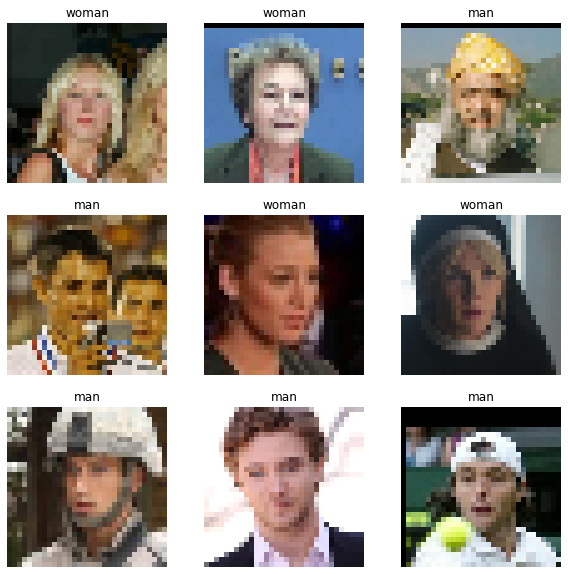

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.95734537


In [ ]:
num_classes = 2
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(32,
                                                              32,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

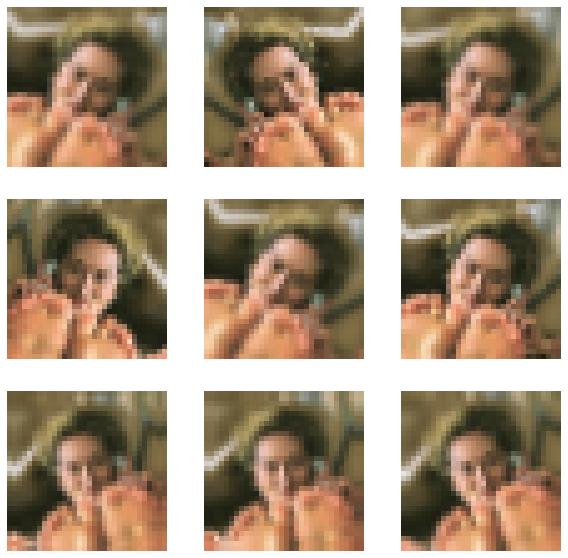

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Modelo CNN

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
114/114 [==============================] - 36s 299ms/step - loss: 0.5434 - accuracy: 0.7158 - val_loss: 0.4593 - val_accuracy: 0.7857
Epoch 2/15
114/114 [==============================] - 26s 230ms/step - loss: 0.4633 - accuracy: 0.7820 - val_loss: 0.4089 - val_accuracy: 0.8170
Epoch 3/15
114/114 [==============================] - 26s 231ms/step - loss: 0.4325 - accuracy: 0.7963 - val_loss: 0.3816 - val_accuracy: 0.8311
Epoch 4/15
114/114 [==============================] - 26s 230ms/step - loss: 0.4060 - accuracy: 0.8139 - val_loss: 0.3451 - val_accuracy: 0.8466
Epoch 5/15
114/114 [==============================] - 26s 229ms/step - loss: 0.3837 - accuracy: 0.8246 - val_loss: 0.3256 - val_accuracy: 0.8594
Epoch 6/15
114/114 [==============================] - 26s 228ms/step - loss: 0.3640 - accuracy: 0.8388 - val_loss: 0.3445 - val_accuracy: 0.8486
Epoch 7/15
114/114 [==============================] - 26s 229ms/step - loss: 0.3525 - accuracy: 0.8437 - val_loss: 0.3039 - val_ac

##Evaluación

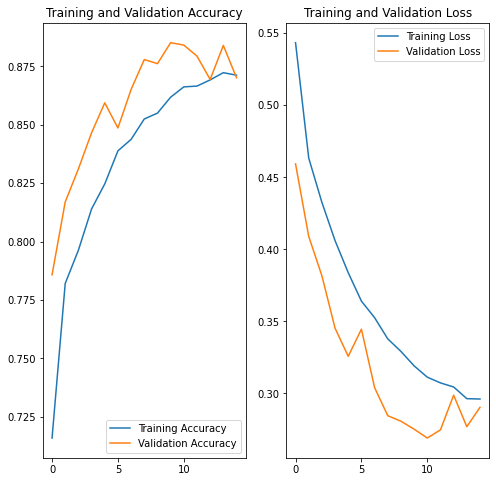

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('figure_1.png')
plt.show()

In [ ]:
model.save('gender_classification')

INFO:tensorflow:Assets written to: gender_classification/assets


In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

Average(val_acc)

0.8586462378501892

#Resultados
Al final se pudo ver como el modelo pudo clasificar satisfactoriamente el genero de las personas por medio de su cara con un 86% de presición aproximadamente.